## S8 - Layer Normalization

#### Target:
    No of parameters should be less than 50k.
    Accuracy of model should be between 70 and 94 which should be achieved in 20 epochs.

#### Result:
    No of parameters of model: 50900
    Best Test Accuracy: 69.33% ( 19th epoch)

#### Analysis:

    Model didn't overfit in initial epochs but it started overfitting in later epochs.
    I initially added Layer normalization to every layer by using which i was able to achieve accuracy upto 53%. In that case model was not overfitting.
    As part of trial and error, i started removing layer normalization layers in few conv blocks which led to 69% accuracy.
    Training Loss was decreasing till 7 epochs and later at 11th epoch there was sudden increase in the training loss.
    No of parameters introduced through LN layer are greater than Batch Normalization.
    I see that Layer normalization may not be good fit for images as it was making model more heavier and also unable to understand basic features.
    I see it misclassified many images as bird and i feel it need to learn more patterns on identifying deer and house as it is still treating many as bird.



### Import heavenly gods / libraries

In [26]:
from __future__ import print_function
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [27]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827 ,0.44653124,), (0.24703233,0.24348505,0.26158768,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827 ,0.44653124,), (0.24703233,0.24348505,0.26158768,))
                                       ])

## Load CIFAR10 dataset

In [121]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Dataloader Arguments and Train/Test Dataloaders

In [122]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Statistics

* Compute mean , standard deviation, variance of training data
* Visualizing images in a batch

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data_tensor = torch.Tensor(train_data)

print('[Train]')
print(' - Numpy Shape:', train.data.shape)
print(' - Tensor Shape:', train_data_tensor.size())
print(' - min:', torch.min(train_data_tensor))
print(' - max:', torch.max(train_data_tensor))
print(' - mean:', torch.mean(train_data_tensor))
print(' - std:', torch.std(train_data_tensor))
print(' - var:', torch.var(train_data_tensor))

def imshow(img, labels):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(labels)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images[0].shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

imshow(make_grid(images), "")


# Define model for layer normalization

C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11

In [ ]:
from model import Model_5

## model summary

In [118]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_nn = Model_5().to(device)
summary(model_nn, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 30, 30]             324
         LayerNorm-2           [-1, 12, 30, 30]          21,600
              ReLU-3           [-1, 12, 30, 30]               0
           Dropout-4           [-1, 12, 30, 30]               0
            Conv2d-5           [-1, 24, 28, 28]           2,592
              ReLU-6           [-1, 24, 28, 28]               0
           Dropout-7           [-1, 24, 28, 28]               0
            Conv2d-8           [-1, 10, 28, 28]             240
              ReLU-9           [-1, 10, 28, 28]               0
          Dropout-10           [-1, 10, 28, 28]               0
        MaxPool2d-11           [-1, 10, 14, 14]               0
           Conv2d-12           [-1, 16, 12, 12]           1,440
        LayerNorm-13           [-1, 16, 12, 12]           4,608
             ReLU-14           [-1

### Functions to train and test the data

In [67]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

* Specified LR Scheduler ( ReduceLROnPlateau ).
* Training data for 20 epochs
* Using SGD as optimizer

In [80]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model_nn =  Model_5().to(device)
optimizer = optim.SGD(model_nn.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel')
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_nn, device, train_loader, optimizer, epoch)
    test_loss = test(model_nn, device, test_loader)
    scheduler.step(test_loss)
    print("LR: ", scheduler.get_last_lr())

EPOCH: 0


Loss=2.0041542053222656 Batch_id=781 Accuracy=22.81: 100%|██████████| 782/782 [00:23<00:00, 33.35it/s]



Test set: Average loss: 1.9141, Accuracy: 2731/10000 (27.31%)

LR:  [0.01]
EPOCH: 1


Loss=1.6876753568649292 Batch_id=781 Accuracy=31.82: 100%|██████████| 782/782 [00:24<00:00, 31.38it/s]



Test set: Average loss: 1.6846, Accuracy: 3481/10000 (34.81%)

LR:  [0.01]
EPOCH: 2


Loss=1.601951241493225 Batch_id=781 Accuracy=39.44: 100%|██████████| 782/782 [00:25<00:00, 30.23it/s]



Test set: Average loss: 1.5393, Accuracy: 4294/10000 (42.94%)

LR:  [0.01]
EPOCH: 3


Loss=1.5422147512435913 Batch_id=781 Accuracy=45.30: 100%|██████████| 782/782 [00:25<00:00, 31.10it/s]



Test set: Average loss: 1.3989, Accuracy: 5025/10000 (50.25%)

LR:  [0.01]
EPOCH: 4


Loss=1.299755334854126 Batch_id=781 Accuracy=50.24: 100%|██████████| 782/782 [00:24<00:00, 31.46it/s]



Test set: Average loss: 1.3327, Accuracy: 5204/10000 (52.04%)

LR:  [0.01]
EPOCH: 5


Loss=0.8321606516838074 Batch_id=781 Accuracy=53.50: 100%|██████████| 782/782 [00:26<00:00, 29.81it/s]



Test set: Average loss: 1.2506, Accuracy: 5502/10000 (55.02%)

LR:  [0.01]
EPOCH: 6


Loss=0.8708576560020447 Batch_id=781 Accuracy=56.27: 100%|██████████| 782/782 [00:23<00:00, 32.98it/s]



Test set: Average loss: 1.1867, Accuracy: 5683/10000 (56.83%)

LR:  [0.01]
EPOCH: 7


Loss=0.79999840259552 Batch_id=781 Accuracy=58.23: 100%|██████████| 782/782 [00:23<00:00, 32.89it/s]



Test set: Average loss: 1.0927, Accuracy: 6080/10000 (60.80%)

LR:  [0.01]
EPOCH: 8


Loss=1.0568913221359253 Batch_id=781 Accuracy=60.21: 100%|██████████| 782/782 [00:25<00:00, 31.09it/s]



Test set: Average loss: 1.0844, Accuracy: 6085/10000 (60.85%)

LR:  [0.01]
EPOCH: 9


Loss=1.022587537765503 Batch_id=781 Accuracy=61.55: 100%|██████████| 782/782 [00:26<00:00, 29.50it/s]



Test set: Average loss: 1.0684, Accuracy: 6167/10000 (61.67%)

LR:  [0.01]
EPOCH: 10


Loss=0.8904616236686707 Batch_id=781 Accuracy=62.69: 100%|██████████| 782/782 [00:24<00:00, 31.40it/s]



Test set: Average loss: 1.0142, Accuracy: 6327/10000 (63.27%)

LR:  [0.01]
EPOCH: 11


Loss=1.298136591911316 Batch_id=781 Accuracy=64.09: 100%|██████████| 782/782 [00:24<00:00, 31.54it/s]



Test set: Average loss: 0.9749, Accuracy: 6451/10000 (64.51%)

LR:  [0.01]
EPOCH: 12


Loss=0.7319707870483398 Batch_id=781 Accuracy=64.91: 100%|██████████| 782/782 [00:26<00:00, 29.17it/s]



Test set: Average loss: 0.9712, Accuracy: 6540/10000 (65.40%)

LR:  [0.01]
EPOCH: 13


Loss=0.8995102643966675 Batch_id=781 Accuracy=66.14: 100%|██████████| 782/782 [00:24<00:00, 31.41it/s]



Test set: Average loss: 0.9868, Accuracy: 6449/10000 (64.49%)

LR:  [0.01]
EPOCH: 14


Loss=0.8795499205589294 Batch_id=781 Accuracy=66.57: 100%|██████████| 782/782 [00:25<00:00, 30.63it/s]



Test set: Average loss: 0.9445, Accuracy: 6640/10000 (66.40%)

LR:  [0.01]
EPOCH: 15


Loss=0.682551920413971 Batch_id=781 Accuracy=67.03: 100%|██████████| 782/782 [00:25<00:00, 30.82it/s]



Test set: Average loss: 0.9936, Accuracy: 6568/10000 (65.68%)

LR:  [0.01]
EPOCH: 16


Loss=1.070536732673645 Batch_id=781 Accuracy=67.95: 100%|██████████| 782/782 [00:25<00:00, 30.25it/s]



Test set: Average loss: 0.9314, Accuracy: 6706/10000 (67.06%)

LR:  [0.01]
EPOCH: 17


Loss=0.481340616941452 Batch_id=781 Accuracy=68.78: 100%|██████████| 782/782 [00:27<00:00, 28.62it/s]



Test set: Average loss: 0.8892, Accuracy: 6812/10000 (68.12%)

LR:  [0.01]
EPOCH: 18


Loss=0.442545086145401 Batch_id=781 Accuracy=68.91: 100%|██████████| 782/782 [00:24<00:00, 31.31it/s]



Test set: Average loss: 0.8685, Accuracy: 6933/10000 (69.33%)

LR:  [0.01]
EPOCH: 19


Loss=0.5539417266845703 Batch_id=781 Accuracy=69.44: 100%|██████████| 782/782 [00:25<00:00, 30.08it/s]



Test set: Average loss: 0.9199, Accuracy: 6715/10000 (67.15%)

LR:  [0.01]


### Plotted graph for training loss, testing loss, training and testing accuracy

Text(0.5, 1.0, 'Test Accuracy')

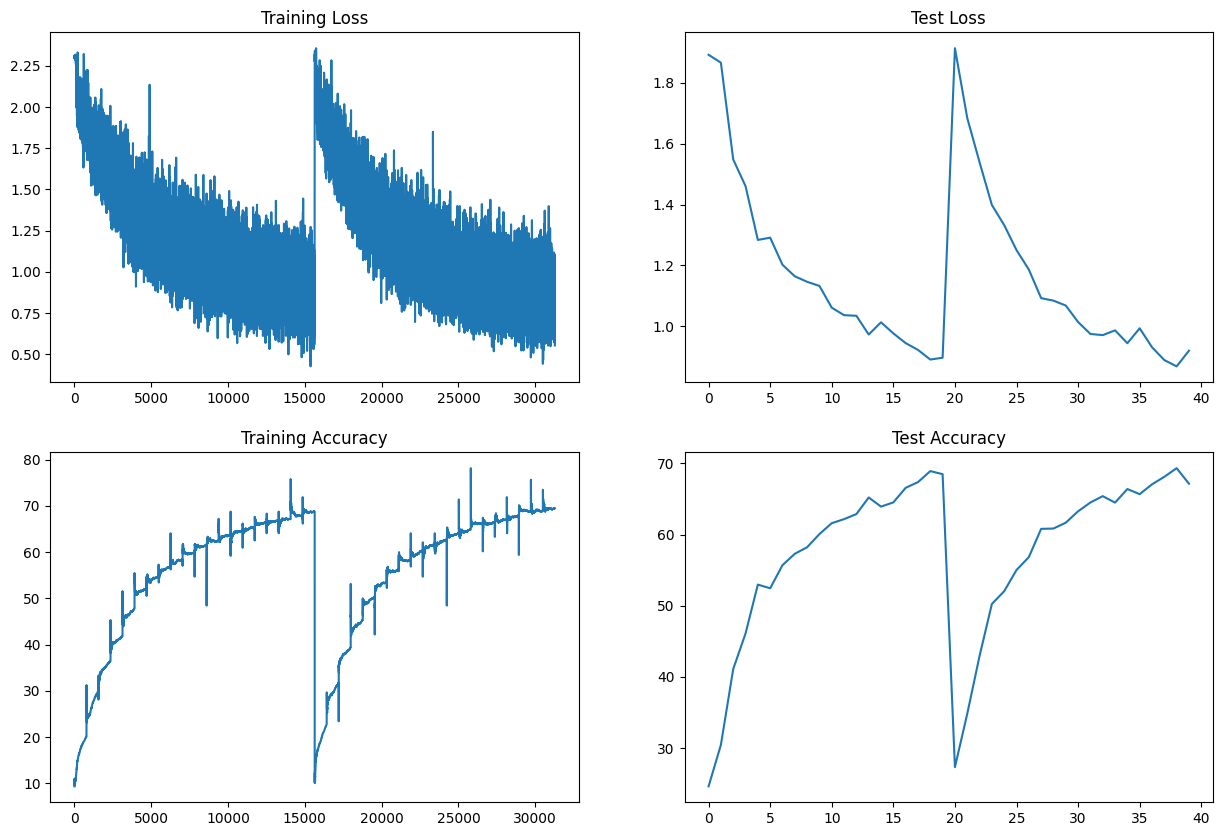

In [117]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Below code is written to find the misclassified images , labels and their correct labels.

In [91]:
# get mismatched images
model_nn.eval()
misclassified_images = []
misclassified_image_labels = []
correct_image_labels = []
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_nn(data)
        # if (not pred.eq(target.view_as(pred))[0]):
        #   misclassified_images.append([data, target])
        pred = output.argmax(dim=1, keepdim=True)
        pred_classes = pred.squeeze().tolist()
        target_classes = target.view_as(pred).squeeze().tolist()
        for index in range(len(pred_classes)):
          if (pred_classes[index] != target_classes[index]):
            misclassified_images.append(data[index].cpu())
            misclassified_image_labels.append(class_labels[pred_classes[index]])
            correct_image_labels.append(class_labels[target_classes[index]])





/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Obtain first 10 misclassified images and their coreesponding ground truth ( actual values) and predicted values

In [89]:
first_ten_misclassified_images = misclassified_images[0:10]
first_ten_misclassified_labels = misclassified_image_labels[0:10]
first_ten_correct_labels = correct_image_labels[0:10]

In [103]:
grid_image = make_grid(first_ten_misclassified_images, nrow=5, normalize=True)

In [24]:
grid_image.shape

torch.Size([3, 70, 172])

In [112]:
misclassified_dict= {}
for index in range(0, len(first_ten_correct_labels)):
  misclassified_dict["GT." + str(index) + ": " + first_ten_correct_labels[index]] = "Pred: " + first_ten_misclassified_labels[index]

In [113]:
misclassified_dict

{'GT.0: frog': 'Pred: deer',
 'GT.1: cat': 'Pred: frog',
 'GT.2: deer': 'Pred: cat',
 'GT.3: dog': 'Pred: cat',
 'GT.4: deer': 'Pred: bird',
 'GT.5: horse': 'Pred: bird',
 'GT.6: dog': 'Pred: duck',
 'GT.7: dog': 'Pred: bird',
 'GT.8: dog': 'Pred: cat',
 'GT.9: deer': 'Pred: bird'}

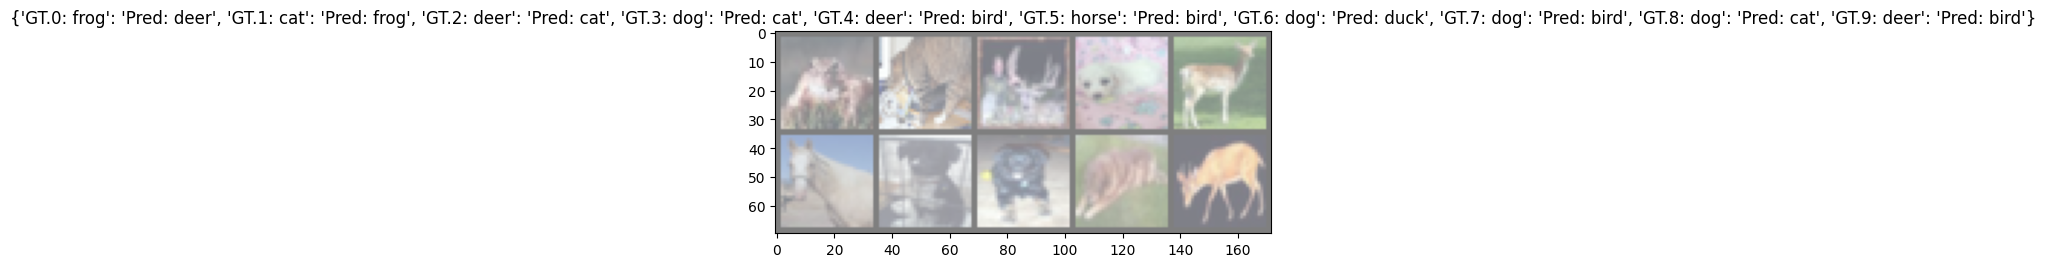

In [116]:

imshow(grid_image, misclassified_dict)